# Chapter 5

In [1]:
import os
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
from theano import shared
import seaborn as sns

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
np.random.seed(0)

In [3]:
# Load data
data = pd.read_csv(os.path.join("Data", "WaffleDivorce.csv"), delimiter=";")

In [4]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [5]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

def unstandardize(std_series, original_series):
    """Given an input series restandardize"""
    unstandardize = std_series*original_series.std() + original_series.mean()
    return unstandardize

#### Code 5.1

In [6]:
# Standard regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

#### Code 5.2

In [7]:
data["MedianAgeMarriage"].std()

1.2436303013880823

#### Code 5.3

In [8]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, .2)
    bA = pm.Normal("bA", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bA*data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    m_5_1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1008.74draws/s]


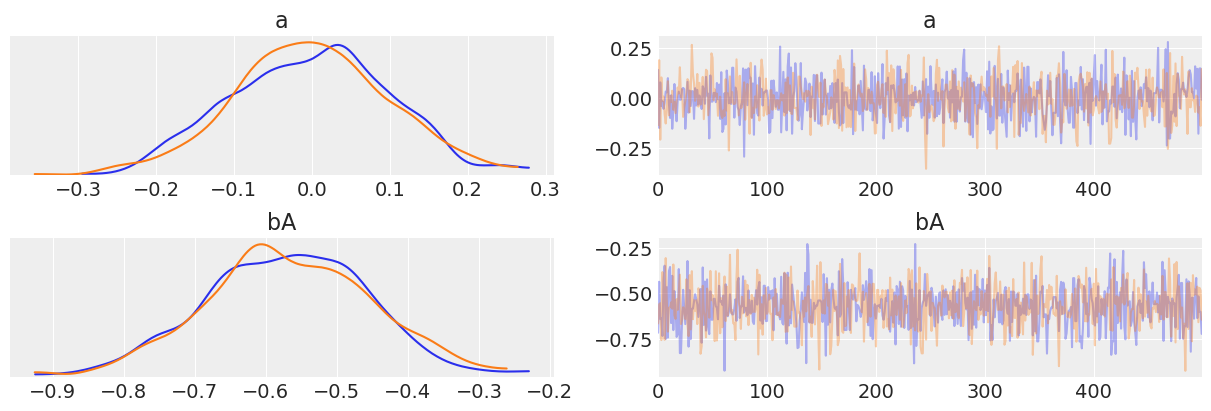

In [9]:
az.plot_trace(m_5_1_trace, var_names = ["a", "bA"]);

#### Code 5.4

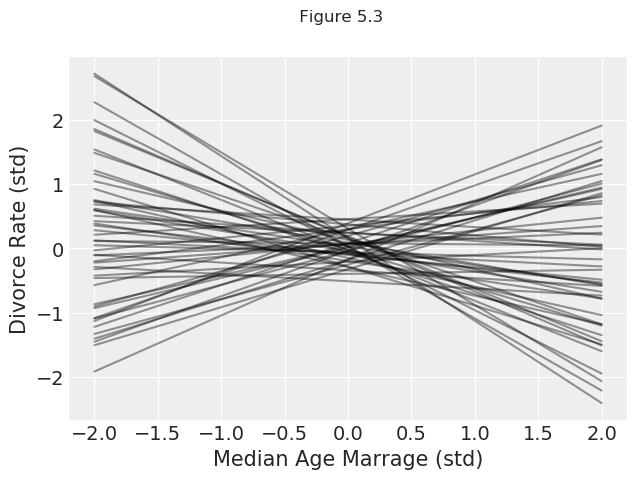

In [10]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, ba in zip(prior_samples["a"][:50], prior_samples["bA"][:50]):
    y = a + ba*x 
    ax.plot(x, y, c="black", alpha=.4)
    
ax.set_xlabel("Median Age Marrage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle(" Figure 5.3");

#### Code 5.5

In [11]:
m_5_1_trace["bA"].shape

(1000,)

In [12]:
# This is equivalent of link function

age_std_seq = np.linspace(-3, 3.2, 30)

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
m_5_1_trace = m_5_1_trace[::10]
mu_pred = np.zeros((len(age_std_seq), len(m_5_1_trace) * m_5_1_trace.nchains))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_1_trace["a"] + m_5_1_trace["bA"]*age_std

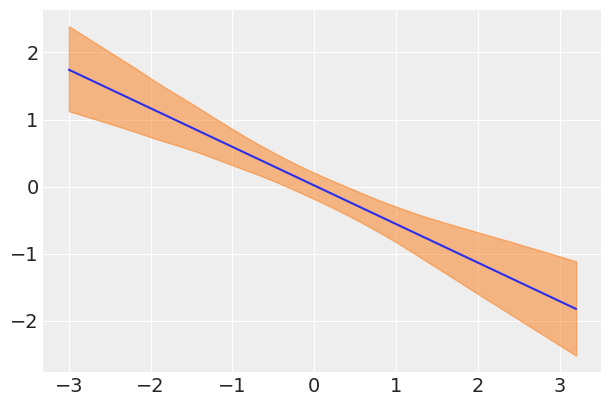

In [13]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred.mean(axis=1)
plt.plot(age_std_seq, mu_mean)

# This is equivalent of Percent Interval
az.plot_hpd(age_std_seq, mu_pred.T);

#### 5.6

In [14]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, .2)
    bM = pm.Normal("bM", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bM*data["Marriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    m_5_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 844.91draws/s] 


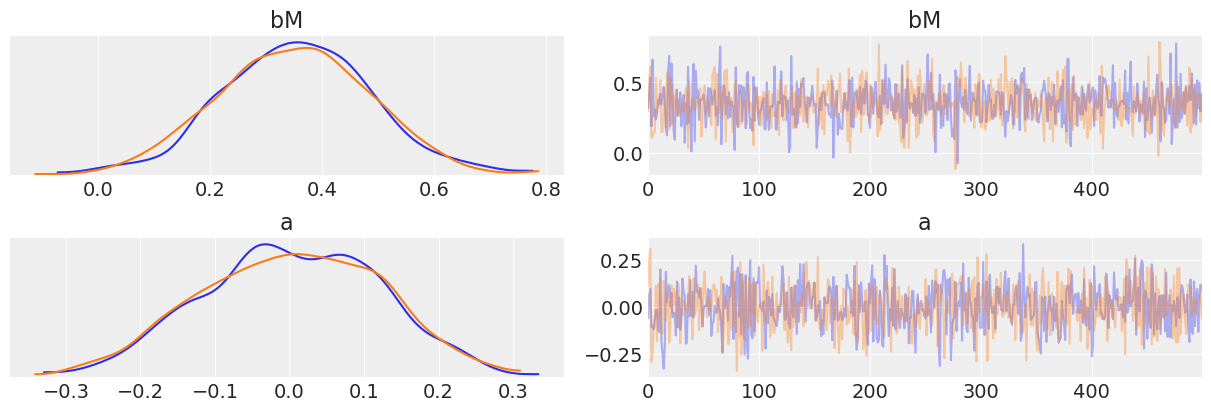

In [15]:
az.plot_trace(m_5_2_trace, var_names=["bM", "a"]);

#### 5.7

#### 5.8

#### 5.9

#### 5.10

In [16]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, .2)
    bA = pm.Normal("bA", 0, .5)
    bM = pm.Normal("bM", 0, .5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bM*data["Marriage_std"] + bA*data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, bA, a]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 706.64draws/s]


In [17]:
pm.summary(m_5_3_trace, var_names=["a", "bM", "bA", "sigma"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.005858,0.096742,0.003124,-0.185885,0.197501,827.340290,1.001299
bM,-0.060471,0.150429,0.005589,-0.375827,0.208550,776.246993,1.000022
bA,-0.605774,0.155065,0.005616,-0.876108,-0.275844,817.973940,0.999942
sigma,0.828467,0.088139,0.002878,0.672774,1.003289,952.490175,0.999336


#### 5.11

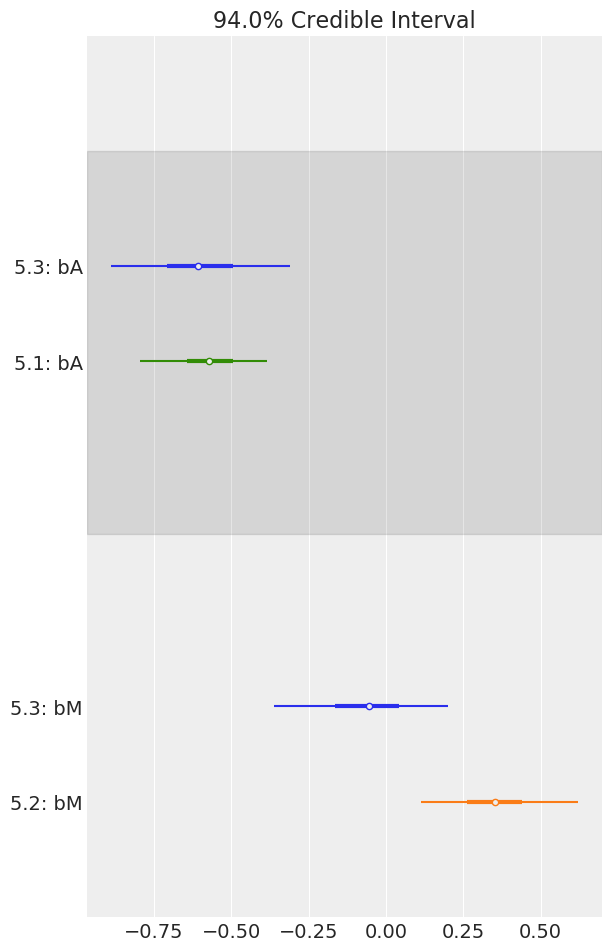

In [18]:
pm.plot_forest([m_5_3_trace, m_5_2_trace, m_5_1_trace,], model_names=["5.3", "5.2", "5.1"], var_names=["bA", "bM"], combined=True);

#### 5.12

In [19]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

#### 5.13

In [20]:
 with pm.Model() as m_5_4:
    a = pm.Normal("a", 0, .2)
    bAM = pm.Normal("bAM", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    
    mu = pm.Deterministic("mu", a+bAM*data["MedianAgeMarriage_std"])

    marriage_std = pm.Normal("divorce_std", mu=mu, sd=sigma, observed = data["Marriage_std"].values)
    prior_samples = pm.sample_prior_predictive()
    m_5_4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAM, a]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 821.74draws/s] 


#### 5.14

In [21]:
mu_m_5_4_mean = m_5_4_trace["mu"].mean(axis=0)
residuals = data["Marriage_std"] - mu_m_5_4_mean

#### 5.15
Something is wrong with this plot. Need to revisit

In [24]:
# We can skip most of the code with the posterior predictive plot functionality in pymc3
with m_5_4:
    m_5_4_ppc = pm.sample_posterior_predictive(m_5_4_trace, var_names=["mu", "divorce_std"], samples=1000)


mu_mean = m_5_4_ppc['mu'].mean(axis=0)
mu_hpd = az.hpd(m_5_4_ppc['mu'], credible_interval=0.89)

D_sim = m_5_4_ppc['divorce_std'].mean(axis=0)
D_PI = az.hpd(m_5_4_ppc['divorce_std'], credible_interval=0.89)

100%|██████████| 1000/1000 [00:01<00:00, 771.07it/s]


#### 5.16

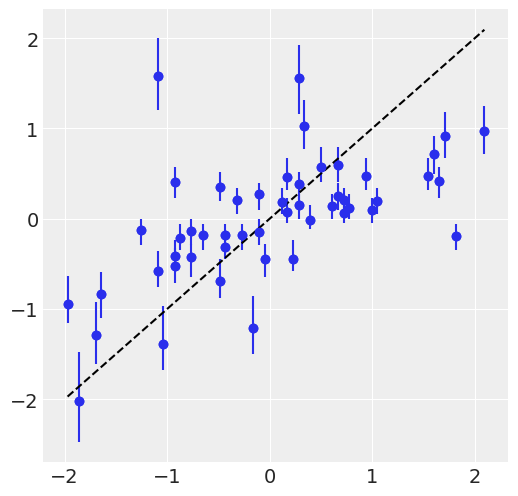

In [25]:
fig, ax = plt.subplots(figsize=(6,6))
plt.errorbar(data["Divorce_std"].values,m_5_4_ppc["divorce_std"].mean(0), yerr=np.abs(m_5_4_ppc["divorce_std"].mean(0) - mu_hpd.T) , fmt='C0o')
ax.scatter(data["Divorce_std"].values, D_sim)

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');


#### 5.18

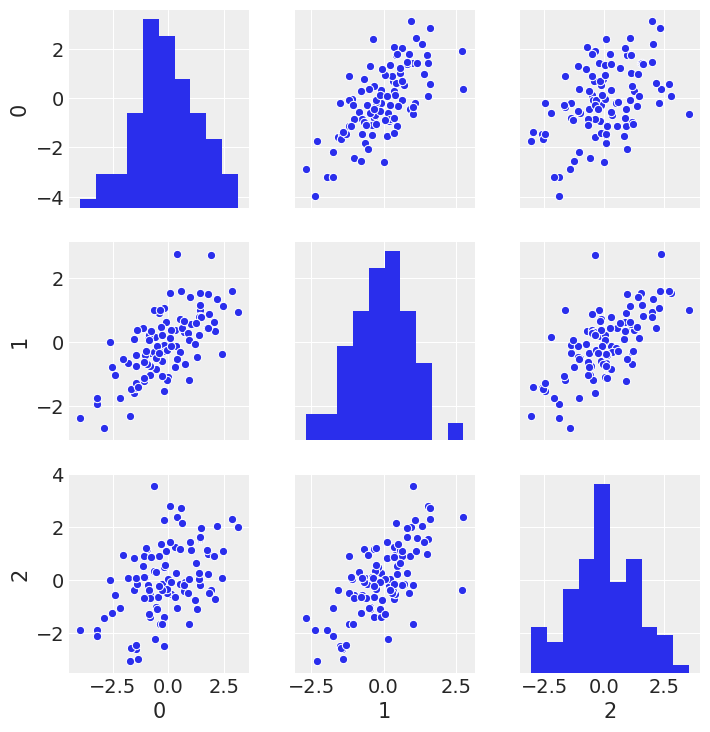

In [26]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### 5.19

In [27]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

# Use Theano shared variables so we can change them later
marriage_shared = shared(data["Marriage_std"].values)
age_shared = shared(data["MedianAgeMarriage_std"].values)

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, .5)
    bM = pm.Normal("bM", 0, .5)

    a = pm.Normal("a", 0, .2)
    mu = pm.Deterministic("mu", a + bA*age_shared + bM*marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"])
    
    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, .5)
    aM = pm.Normal("aM", 0, .2)
    mu_M = pm.Deterministic("mu_m", aM + bAM*age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"])
        
    m5_3_A_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [aM, bAM, sigma_m, a, bM, bA, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 694.94draws/s]
The acceptance probability does not match the target. It is 0.8870925122522039, but should be close to 0.8. Try to increase the number of tuning steps.


#### 5.20

In [28]:
# We're setting this to 50 to match the shape of our input
A_seq = np.linspace(-2, 2, 50)
A_seq.shape

(50,)

#### 5.21
No idea how to do counterfactual correctly

In [29]:
# With PyMC3 we have to simulate in each model separately

# Simulate the marriage rates at each age first
age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace)
    

100%|██████████| 1000/1000 [00:03<00:00, 331.71it/s]


#### 5.22

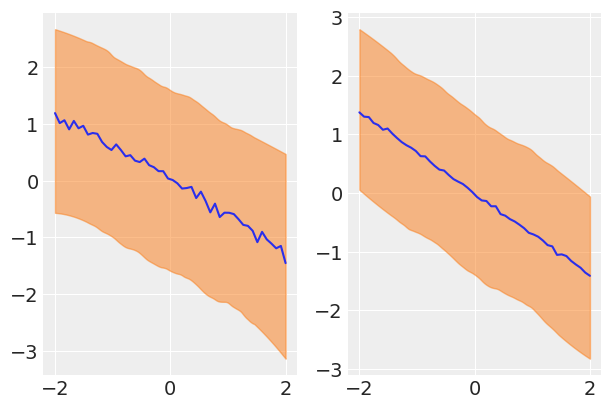

In [30]:
_, ax = plt.subplots(1, 2)
ax[0].plot(A_seq, m5_3_M_marriage['divorce'].mean(0))
az.plot_hpd(A_seq, m5_3_M_marriage['divorce'], ax=ax[0])

ax[1].plot(A_seq, m5_3_M_marriage['marriage'].mean(0))
az.plot_hpd(A_seq, m5_3_M_marriage['marriage'], ax=ax[1])

#### 5.23

In [31]:
# We're setting this to 50 to match the shape of our input
A_seq = (np.linspace(20,30,50) - 26.1)/1.24

age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

# Average first and last column and take difference
m5_3_M_ppc["divorce"][:,-1].mean() - m5_3_M_ppc["divorce"][:,0].mean()

100%|██████████| 1000/1000 [00:03<00:00, 317.11it/s]


-5.0745899749488315

#### 5.24

In [32]:
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_shared.set_value(marriage_counter_factual_x)

# Fix age to zero
age_shared.set_value(np.zeros(50))

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)


100%|██████████| 1000/1000 [00:02<00:00, 410.13it/s]


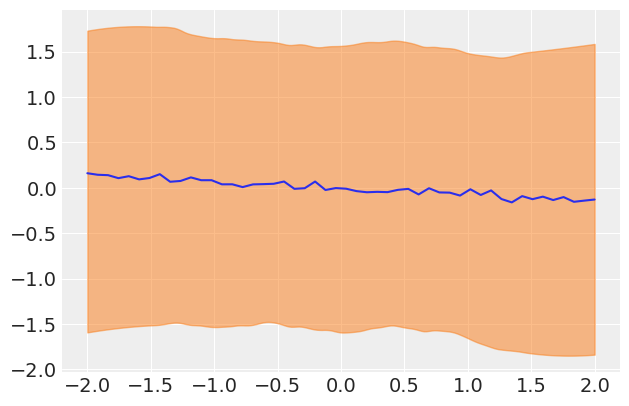

In [33]:
fig, ax = plt.subplots()
divorce_means = m5_3_M_ppc["divorce"].mean(axis=0)

ax.plot(marriage_counter_factual_x, m5_3_M_ppc['divorce'].mean(0))
az.plot_hpd(marriage_counter_factual_x, m5_3_M_ppc['divorce'], ax=ax)

#### 5.25

In [34]:
A_seq = np.linspace(-2, 2, 30)

#### 5.26

In [35]:
# Get the samples from Age Marriage model first
with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace, var_names=["sigma_m", "aM", "bAM"], samples=1000)
    

100%|██████████| 1000/1000 [00:00<00:00, 15970.82it/s]


In [36]:
marriage_mu_counterfactual = np.outer(m5_3_M_marriage["aM"] + m5_3_M_marriage["bAM"], A_seq)
marriage_mu_counterfactual.shape

(1000, 30)

In [37]:
M_sim = stats.norm(loc=marriage_mu_counterfactual.T, scale=m5_3_M_marriage["sigma_m"]).rvs()
M_sim.shape

(30, 1000)

#### 5.27

In [38]:
with m5_3_A:
    m5_3_M_divorce = pm.sample_posterior_predictive(m5_3_A_trace, var_names=["sigma", "bM", "bA", "a"], samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 14927.84it/s]


In [39]:
D_sim = np.zeros((30, 1000))
a, bM, bA = m5_3_M_divorce["a"], m5_3_M_divorce["bM"], m5_3_M_divorce["bA"]

for i, age_counterfactual in enumerate(A_seq):
    divorce_mu_counterfactual = a + bA*age_counterfactual + bM*M_sim[i,:]
    samples = stats.norm(divorce_mu_counterfactual, m5_3_M_divorce["sigma"]).rvs()
    D_sim[i,:] = samples


#### 5.28

In [40]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### 5.29

In [41]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(d["mass"])

#### 5.30

In [42]:
# This is meant to fail!
with pm.Model() as m5_5_draft:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN*d["N"])
    
    K = pm.Normal("K", mu, sigma, observed=d["K"])
    
    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]
Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]/Users/canyon/.miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
K   NaN


ParallelSamplingError: Bad initial energy

/Users/canyon/.miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


#### 5.32

In [43]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

#### 5.32

In [44]:
dcc = d.dropna(axis=0)
dcc.shape

(17, 11)

#### 5.33

In [45]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5_draft:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN*shared_N)
    
    K = pm.Normal("K", mu, sigma, observed=dcc["K"])
    
    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1097.19draws/s]


#### Bonus: Recreate Figure 5.6 

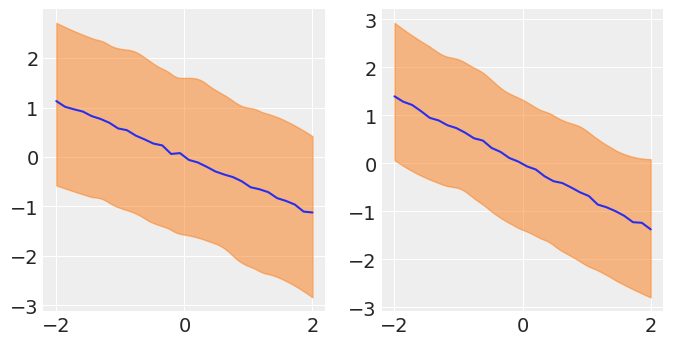

In [46]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[1].plot(A_seq, M_sim.mean(1))
az.plot_hpd(A_seq, M_sim.T, ax=axes[1])

axes[0].plot(A_seq, D_sim.mean(1))
az.plot_hpd(A_seq, D_sim.T, ax=axes[0])

#### 5.34

In [47]:
xseq = [-2,2]
shared_N.set_value(np.array(xseq))
with m5_5_draft:
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()


(-2, 2)

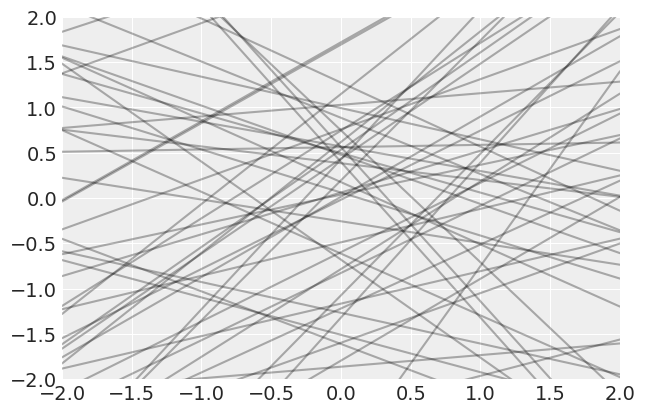

In [48]:
fig, ax = plt.subplots()

for i in range(50):
    ax.plot(xseq,m5_5_draft_prior_predictive["K"][i], c="black", alpha=.3 )
ax.set_xlim(xseq)
ax.set_ylim(xseq)

#### 5.35

In [49]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, .5)
    a = pm.Normal("a", 0, .2)
    mu = pm.Deterministic("mu", a + bN*shared_N)
    
    K = pm.Normal("K", mu, sigma, observed=dcc["K"])
    
    m5_5_trace = pm.sample()

m5_5_data = az.from_pymc3(m5_5_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 826.18draws/s] 


#### 5.36

In [50]:
az.summary(m5_5_trace, var_names = ["a", "bN", "sigma"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.031,0.160,-0.284,0.318,0.004,0.005,1316.0,527.0,1320.0,773.0,1.0
bN,0.119,0.240,-0.336,0.542,0.006,0.006,1664.0,790.0,1675.0,740.0,1.0
sigma,1.099,0.199,0.761,1.469,0.006,0.005,966.0,896.0,1053.0,762.0,1.0


#### 5.37

100%|██████████| 4000/4000 [00:01<00:00, 2574.85it/s]


(-1.5, 2.2)

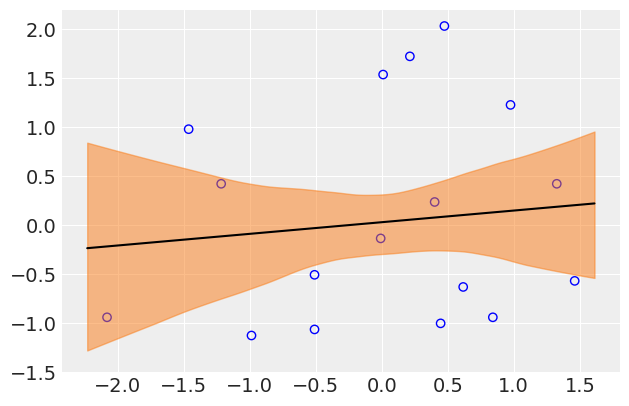

In [51]:
xseq = np.linspace(dcc["N"].min() - .15, dcc["N"].max() + .15, 30)

shared_N.set_value(xseq)

with m5_5:
    m5_5_posterior_predictive = pm.sample_posterior_predictive(m5_5_trace, var_names=["mu"], samples=4000)

mu_mean = m5_5_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors='none', edgecolors='b') 
az.plot_hpd(xseq, m5_5_posterior_predictive["mu"], ax=ax)
ax.set_ylim(-1.5, 2.2)

#### 5.38

In [52]:
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_6:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, .5)
    a = pm.Normal("a", 0, .2)
    mu = pm.Deterministic("mu", a + bM*shared_M)
    
    K = pm.Normal("K", mu, sigma, observed=dcc["K"])
    
    m5_6_trace = pm.sample()
    
m5_6_data = az.from_pymc3(m5_6_trace)
az.summary(m5_6_trace, var_names=["bM", "a", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 978.55draws/s] 


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,-0.305,0.254,-0.801,0.150,0.007,0.006,1190.0,846.0,1224.0,705.0,1.0
a,0.045,0.152,-0.205,0.353,0.004,0.004,1348.0,574.0,1348.0,791.0,1.0
sigma,1.054,0.190,0.745,1.423,0.006,0.005,866.0,866.0,867.0,681.0,1.0


#### 5.39
Why dont these values match the book?

In [53]:
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_7:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, .5)
    bM = pm.Normal("bM", 0, .5)
    a = pm.Normal("a", 0, .2)
    
    mu = pm.Deterministic("mu", a + bN*shared_N + bM*shared_M)
    
    K = pm.Normal("K", mu, sigma, observed=dcc["K"])
    
    m5_7_trace = pm.sample(tune=2000)
    
m5_7_data = az.from_pymc3(m5_7_trace)
az.summary(m5_7_trace, var_names=[ "a","bN","bM","sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, bN, sigma]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:07<00:00, 702.50draws/s] 


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.065,0.162,-0.239,0.376,0.005,0.005,1100.0,485.0,1099.0,601.0,1.0
bN,0.374,0.258,-0.098,0.837,0.011,0.007,598.0,598.0,596.0,553.0,1.0
bM,-0.494,0.254,-0.968,-0.014,0.010,0.007,628.0,628.0,629.0,661.0,1.0
sigma,0.970,0.186,0.647,1.313,0.007,0.005,741.0,741.0,715.0,551.0,1.0


#### 5.40

(<Figure size 600x940 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c261a10b8>],
       dtype=object))

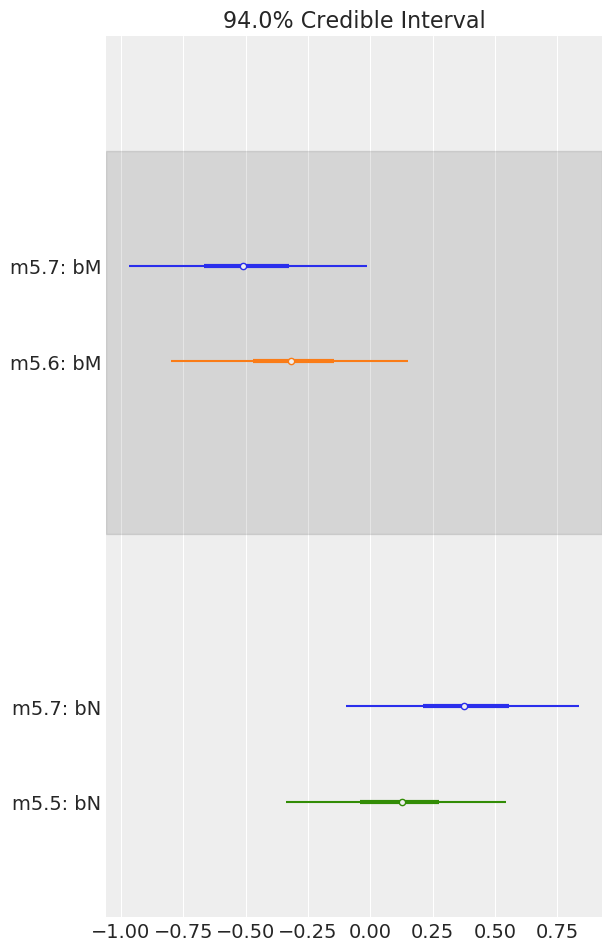

In [54]:
az.plot_forest([m5_7_data, m5_6_data, m5_5_data], model_names=["m5.7", "m5.6", "m5.5"], var_names=["bM", "bN"], combined=True)

#### 5.41?
Waiting on confirmation from Professor McElreath

100%|██████████| 4000/4000 [00:01<00:00, 2031.36it/s]


(-1.5, 2.2)

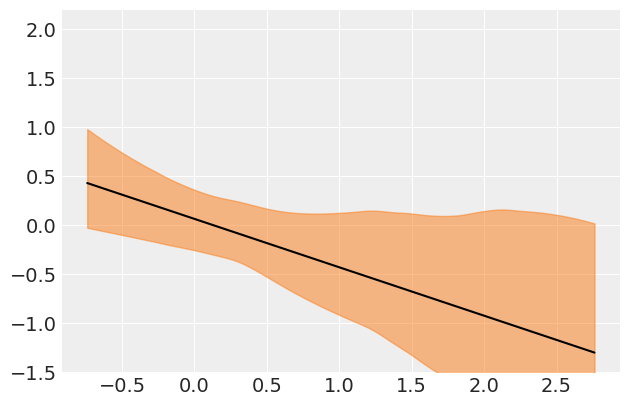

In [55]:
xseq = np.linspace(dcc["M"].min() - .15, dcc["M"].max() + .15, 30)
shared_N.set_value(np.zeros(30))
shared_M.set_value(xseq)


with m5_7:
    m5_7_posterior_predictive = pm.sample_posterior_predictive(m5_7_trace, var_names=["mu"], samples=4000)

mu_mean = m5_7_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
az.plot_hpd(xseq, m5_7_posterior_predictive["mu"], ax=ax)

ax.set_ylim(-1.5, 2.2)


#### 5.42

In [56]:
# M -> K <- N
# M -> N

n = 100
M = stats.norm().rvs(n)
N = stats.norm(M).rvs(n)
K = stats.norm(N-M).rvs(n)
d_sim = pd.DataFrame({"K":K, "M":M, "N":N})

#### 5.43

In [57]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N-M).rvs(100)
d_sim2 = pd.DataFrame({"K":K, "M":M, "N":N})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N-M).rvs(100)
d_sim3 = pd.DataFrame({"K":K, "M":M, "N":N})

#### 4.45

In [58]:
d = pd.read_csv(os.path.join("Data", "Howell1.csv"), delimiter=";")
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


#### 5.46

In [59]:
mu_female = stats.norm(178, 20).rvs(1000)
mu_male = stats.norm(178, 20).rvs(1000) + stats.norm(0, 10).rvs(1000)

az.summary({"mu_female":mu_female, "mu_male":mu_male})

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_female,177.797,20.183,137.768,212.270,0.648,0.459,969.0,969.0,967.0,915.0,NaN
mu_male,176.679,22.019,136.470,219.987,0.714,0.505,951.0,951.0,943.0,854.0,NaN


#### 5.48

In [60]:
sex = d["male"].values

with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed = d["height"])
    m5_8_trace = pm.sample()
    
az.summary(m5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:06<00:00, 293.27draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],134.969,1.665,131.784,137.998,0.046,0.032,1316.0,1314.0,1317.0,793.0,1.0
mu[1],142.629,1.626,139.499,145.452,0.044,0.031,1361.0,1360.0,1358.0,811.0,1.0
sigma,27.377,0.851,25.769,28.897,0.021,0.015,1583.0,1583.0,1555.0,664.0,1.0


#### 5.49

In [61]:
# With PyMC3 it's easier just to create a determinstic that includes both values
sex = d["male"].values

with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed = d["height"])
    diff_fm = pm.Deterministic("diff", mu[0]-mu[1])
    m5_8_trace = pm.sample()
    
az.summary(m5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:04<00:00, 482.37draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],134.874,1.680,131.982,138.171,0.048,0.034,1231.0,1229.0,1228.0,738.0,1.01
mu[1],142.602,1.742,139.407,145.990,0.058,0.041,911.0,911.0,903.0,746.0,1.00
sigma,27.398,0.794,25.990,28.915,0.022,0.016,1289.0,1274.0,1306.0,797.0,1.00
diff,-7.728,2.475,-12.647,-3.469,0.079,0.056,976.0,960.0,977.0,856.0,1.00


#### 5.50

In [62]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### 5.51

In [63]:
d["clade_id"] = pd.Categorical(d["clade"]).codes

#### 5.52

/Users/canyon/.miniconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/canyon/.miniconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00,

(<Figure size 600x440 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2540f0f0>],
       dtype=object))

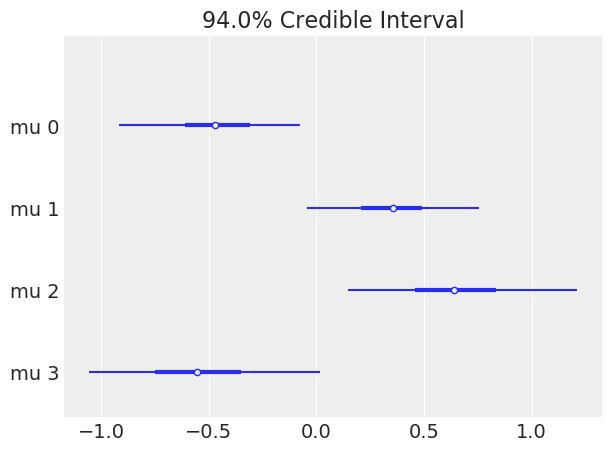

In [64]:
d["K"] = standardize(d["kcal.per.g"])

with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, .5, shape=d["clade_id"].max()+1)
    K = pm.Normal("K", mu[d["clade_id"]], sigma, observed = d["K"])
    
    m5_9_trace = pm.sample()
    
az.plot_forest(m5_9_trace, combined=True, var_names=["mu"])

#### 5.53

In [65]:
d["house"] = np.random.randint(0, 4, size=d.shape[0])

#### 5.54

In [66]:
with pm.Model() as m5_10:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", 0, .5, shape=d["house"].max()+1)
    mu_clade = pm.Normal("mu_clade", 0, .5, shape=d["clade_id"].max()+1)
    mu = mu_clade[d["clade_id"].values] + mu_house[d["house"].values]
    
    K = pm.Normal("K", mu, sigma, observed = d["K"])
    
    m5_9_trace = pm.sample()
    
az.summary(m5_9_trace, var_names=["mu_clade", "mu_house"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_clade, mu_house, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 674.40draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_clade[0],-0.450,0.284,-1.003,0.063,0.011,0.008,712.0,582.0,702.0,746.0,1.00
mu_clade[1],0.361,0.277,-0.140,0.903,0.010,0.007,737.0,687.0,738.0,884.0,1.00
mu_clade[2],0.596,0.299,0.076,1.212,0.010,0.007,887.0,887.0,892.0,877.0,1.00
mu_clade[3],-0.506,0.331,-1.158,0.087,0.010,0.009,1050.0,744.0,1036.0,648.0,1.00
mu_house[0],0.066,0.307,-0.478,0.634,0.011,0.008,787.0,719.0,787.0,807.0,1.01
mu_house[1],0.019,0.299,-0.542,0.541,0.009,0.008,1031.0,622.0,1028.0,691.0,1.01
mu_house[2],0.030,0.276,-0.487,0.542,0.010,0.008,734.0,672.0,731.0,700.0,1.00
mu_house[3],-0.192,0.320,-0.805,0.397,0.009,0.009,1136.0,643.0,1140.0,724.0,1.00


## Extra code
Code that recreates some of the figures whos code isnt included in the book

In [67]:
# Change domain of vars back to domain of original units
regular_age_seq = unstandardize(age_std_seq, data["MedianAgeMarriage"])
regular_divorce_seq = unstandardize(mu_mean, data["Divorce"])
regular_divorce_seq_pred = unstandardize(mu_pred, data["Divorce"])

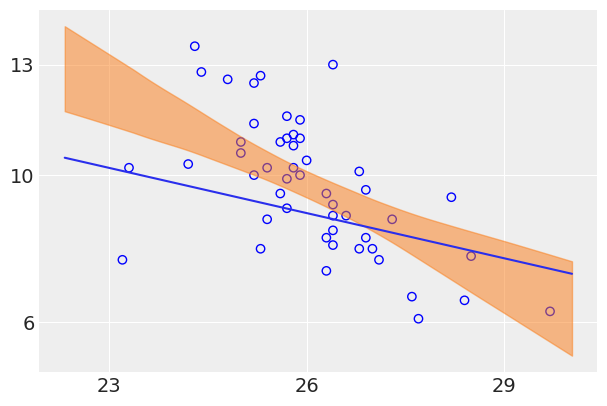

In [68]:
fig, ax = plt.subplots()

ax.scatter(data["MedianAgeMarriage"], data["Divorce"], facecolors='none', edgecolors='b')
ax.set_yticks([13, 10, 6])
ax.set_xticks([23, 26, 29])
ax.plot(regular_age_seq, regular_divorce_seq)
az.plot_hpd(regular_age_seq, regular_divorce_seq_pred.T)